**Transforming Audio-to-Mel Sectrogram**

The purpose of this Notebook is to preprocess and convert bird call data used in Kaggle's BirdCLEF 2025 competition into a format that can be used in machine learning models.

By running this Notebook, the birdsong data will be converted and stored in a mel-spectrogram format suitable as input to the machine learning model.

## Import Libraries

In [1]:
import os
import cv2 # OpenCV library for image processing and computer vision
import math
import time
import librosa # Audio analysis library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # A library for displaying progress bars for loops

import torch # PyTorch machine learning framework
import warnings
# warnings.filterwarnings("ignore")

In [2]:
class Config:
    # If set to True, it limits the number of samples to be processed in subsequent data processing, speeding up development and testing.
    DEBUG_MODE: bool = False

    OUTPUT_DIR: str = "/kaggle/working"
    DATA_ROOT: str = "/kaggle/input/birdclef-2025"

    # Set the sampling rate of the speech data to 32 kHz.
    FS: int = 32000

    # Mel spectrogram parameters

    # The Fast Fourier Transform (FFT) window size when performing the Sort Time Fourier Transform(STFT).
    # The larget the window size, the higher the frequency resolution, but the lower the time resolution.
    N_FFT: int = 1034

    # The STFT window hop size (movement).
    # The smaller the value, the higher the time resolution, but the higher the computational cost.
    HOP_LENGTH: int = 64

    # The number of mel filter banks in the mel spectrogram.
    # It will be the height (number of frequency bins) of the generated mel spectrogram.
    N_MELS: int = 136

    # The lowest frequency used in the mel spectrogram calculation (unit: Hz).
    FMIN: int = 20

    # The highest frequency used in the mel spectrogram calculation (unit: Hz).
    FMAX: int = 16000

    # The target length in seconds for processing audio data.
    # Based on this value, the audio data is trimmed.
    TARGET_DURATION: float = 5.0

    # The target shape (height, width) of the generated mel-spectrogram image.
    # After audio processing, the image will be reized to this shape.
    TARGET_SHAPE: tuple[int, int] = (256, 256)

    # The maximum number of samples to be processed.
    N_MAX: int | None = 50 if DEBUG_MODE else None

config: Config = Config()

In [3]:
print(f"Debug mode: {config.DEBUG_MODE}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

Debug mode: False
Max samples to process: ALL


# Load Data

In [4]:
# Load taxonomy (information about biological classification systems) data
taxonomy_df: pd.DataFrame = pd.read_csv(f"{config.DATA_ROOT}/taxonomy.csv")
species_class_map: dict[str, str] = dict(zip(taxonomy_df["primary_label"], taxonomy_df["class_name"]))

In [5]:
taxonomy_df.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


In [6]:
# Load training metadata
train_df: pd.DataFrame = pd.read_csv(f"{config.DATA_ROOT}/train.csv")

In [7]:
train_df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


# Preprocess Data

In [8]:
# Create a label list and mapping dictionary
label_list: list[str] = sorted(train_df["primary_label"].unique())
label_id_list: list[int] = list(range(len(label_list)))
label2id: dict[str, int] = dict(zip(label_list, label_id_list))
id2label: dict[int, str] = dict(zip(label_id_list, label_list))

print(f"Found {len(label_list)} unique species")

Found 206 unique species


In [9]:
# Create a dataframe for preprcessing
working_df: pd.DataFrame = train_df[["primary_label", "rating", "filename"]].copy()

In [10]:
working_df["target"] = working_df.primary_label.map(label2id)

In [11]:
working_df["filepath"] = config.DATA_ROOT + "/train_audio/" + working_df.filename

In [12]:
working_df["samplename"] = working_df.filename.map(lambda x: x.split("/")[0] + "-" + x.split("/")[-1].split(".")[0])

In [13]:
working_df["class"] = working_df.primary_label.map(lambda x: species_class_map.get(x, "Unknown"))

In [14]:
working_df.head()

,primary_label,rating,filename,target,filepath,samplename,class
0,1139490,0.0,1139490/CSA36385.ogg,0,/kaggle/input/birdclef-2025/train_audio/113949...,1139490-CSA36385,Insecta
1,1139490,0.0,1139490/CSA36389.ogg,0,/kaggle/input/birdclef-2025/train_audio/113949...,1139490-CSA36389,Insecta
2,1192948,0.0,1192948/CSA36358.ogg,1,/kaggle/input/birdclef-2025/train_audio/119294...,1192948-CSA36358,Insecta
3,1192948,0.0,1192948/CSA36366.ogg,1,/kaggle/input/birdclef-2025/train_audio/119294...,1192948-CSA36366,Insecta
4,1192948,0.0,1192948/CSA36373.ogg,1,/kaggle/input/birdclef-2025/train_audio/119294...,1192948-CSA36373,Insecta


In [15]:
total_samples: int = min(len(working_df), config.N_MAX or len(working_df))

In [16]:
print(f"Total samples to process: {total_samples} out of {len(working_df)} available")

Total samples to process: 28564 out of 28564 available


In [17]:
# Sample by class
print(working_df["class"].value_counts())

class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [18]:
def audio2melspec(audio_data: np.ndarray) -> np.ndarray:
    """
    Converts audio data to a normalized Mel spectrogram.

    This function takes a NumPy array representing audio data, calculates its
    Mel spectrogram, converts it to the decibel scale, and normalizes the
    values to the range [0, 1]. It handles potential NaN values in the input
    audio data by filling them with the mean of the non-NaN values.

    Args:
        audio_data (np.ndarray): A NumPy array containing the audio time series data.
                                 Expected to be a 1D array of floating-point numbers.

    Returns:
        np.ndarray: A 2D NumPy array representing the normalized Mel spectrogram.
                    The shape is (n_mels, time_frames), where n_mels is the
                    number of Mel bands and time_frames depends on the length
                    of the audio data and the hop length. The values are
                    normalized to the range [0, 1].
    """
    
    if np.isnan(audio_data).any():
        mean_signal: float = np.nanmean(audio_data)
        audio_data: np.ndarray = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec: np.ndarray = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db: np.ndarray = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm: np.ndarray = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)

    return mel_spec_norm

# Audio Processing

In [19]:
# Start audio processing
print(f"{'DEBUG MODE - Processing only 50 samples' if config.DEBUG_MODE else 'FULL MODE - Processing all samples'}")

FULL MODE - Processing all samples


In [20]:
start_time: float = time.time()
all_bird_data: dict[str, np.float32] = {}
errors: list[tuple[str, str]] = []

for i, row in tqdm(working_df.iterrows(), total=total_samples):
    if config.N_MAX is not None and i >= config.N_MAX:
        break
    
    try:
        # Load audio data
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        # Calculate target sample length (e.g., 5 seconds)
        target_samples: int = int(config.TARGET_DURATION * config.FS)

        # Repeat audio if too short
        if len(audio_data) < target_samples:
            n_copy: int = math.ceil(target_samples / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        # Split into 5-second segments and select the one with highest energy
        segment_len = target_samples
        num_segments = len(audio_data) // segment_len

        if num_segments == 0:
            segment = np.pad(audio_data, (0, target_samples - len(audio_data)), mode="constant")
        else:
            energies = []
            for j in range(num_segments):
                start = j * segment_len
                end = start + segment_len
                seg = audio_data[start:end]
                energy = np.mean(seg ** 2)
                energies.append((energy, start, end))

            # Choose the loudest segment
            _, best_start, best_end = sorted(energies, reverse=True)[0]
            segment = audio_data[best_start:best_end]

        # Pad segment if still too short
        if len(segment) < target_samples:
            segment = np.pad(segment, (0, target_samples - len(segment)), mode="constant")

        # Convert to mel spectrogram
        mel_spec: np.ndarray = audio2melspec(segment)

        # Resize if needed
        if mel_spec.shape != config.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        # Store the result
        all_bird_data[row.samplename] = mel_spec.astype(np.float32)

    except Exception as e:
        print(f"Error processing {row.filepath}: {e}")
        errors.append((row.filepath, str(e)))

end_time: float = time.time()

  0%|          | 0/28564 [00:00<?, ?it/s]

In [21]:
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
print(f"Failed to process {len(errors)} files")

Processing completed in 3371.36 seconds
Successfully processed 28564 files out of 28564 total
Failed to process 0 files


In [22]:
samples: list = []
displayed_classes = set()

In [23]:
max_samples: int = min(4, len(all_bird_data))

In [24]:
for i, row in working_df.iterrows():
    if i >= (config.N_MAX or len(working_df)):
        break
        
    if row["samplename"] in all_bird_data:
        if config.DEBUG_MODE:
            if row["class"] not in displayed_classes:
                samples.append((row["samplename"], row["class"], row["primary_label"]))
                displayed_classes.add(row["class"])
        else:
            if row["class"] not in displayed_classes:
                samples.append((row["samplename"], row["class"], row["primary_label"]))
                displayed_classes.add(row["class"])
        
        if len(samples) >= max_samples:  
            break

# Visualization

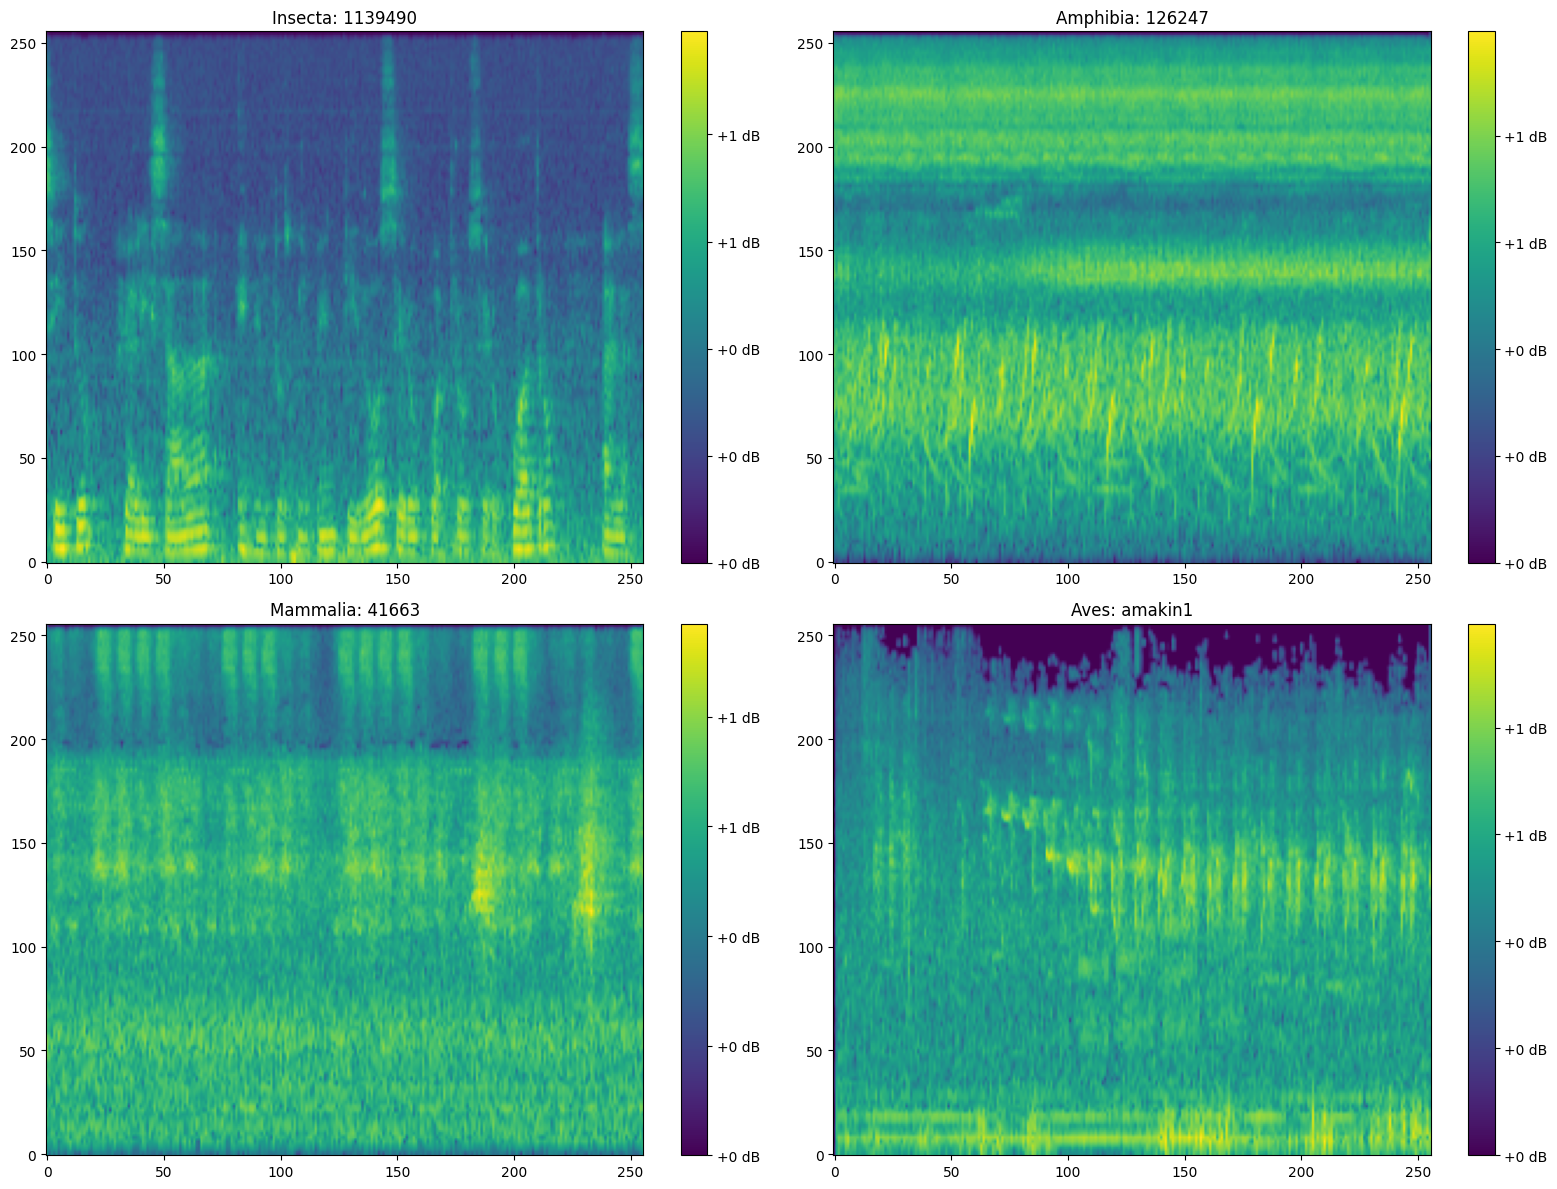

In [25]:
if samples:
    plt.figure(figsize=(16, 12))
    
    for i, (samplename, class_name, species) in enumerate(samples):
        plt.subplot(2, 2, i+1)
        plt.imshow(all_bird_data[samplename], aspect="auto", origin="lower", cmap="viridis")
        plt.title(f"{class_name}: {species}")
        plt.colorbar(format="%+2.0f dB")
    
    plt.tight_layout()
    debug_note = "debug_" if config.DEBUG_MODE else ""
    plt.savefig(f"{debug_note}melspec_examples.png")
    plt.show()

# Save Data

In [26]:
output_path: str = f"{config.OUTPUT_DIR}/birdclef2025_melspec_{int(config.TARGET_DURATION)}sec_{config.TARGET_SHAPE[0]}_{config.TARGET_SHAPE[1]}.npy"

In [27]:
np.save(output_path, all_bird_data)